<a href="https://colab.research.google.com/github/hamiin47/OB-session/blob/main/Assign_0314.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **7.5 부스팅**

- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
- 부스팅 방법 : 에이다부스트 / 그레이디언트 부스팅

**7.5.1 에이다부스트**
- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것이다.-> 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.

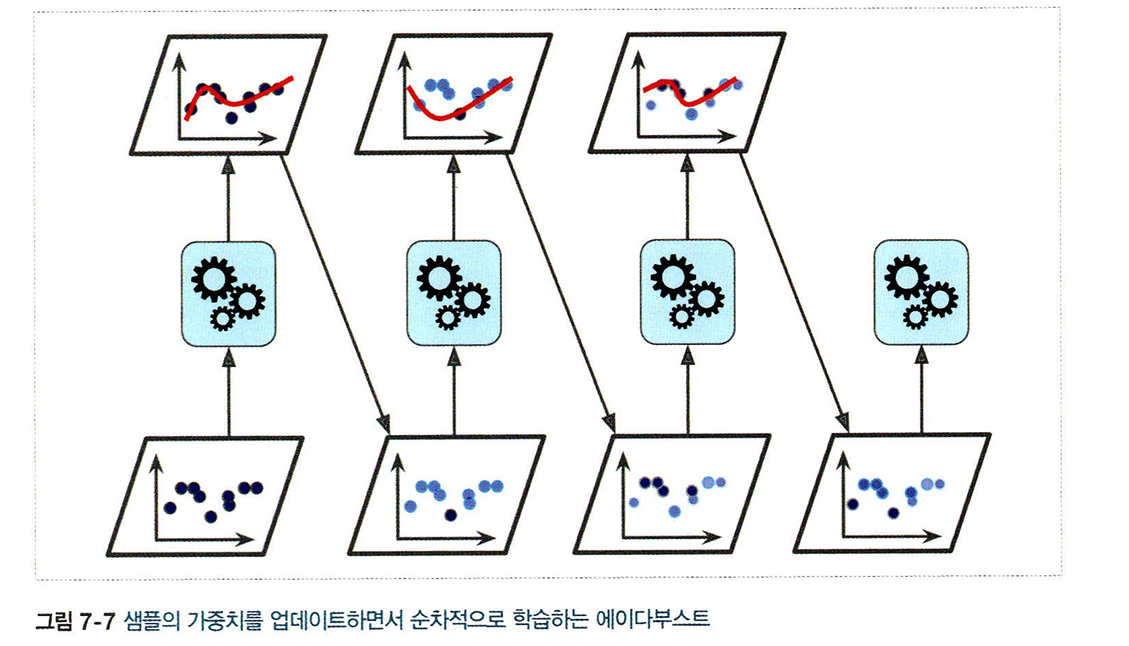

[에이다부스트 알고리즘]
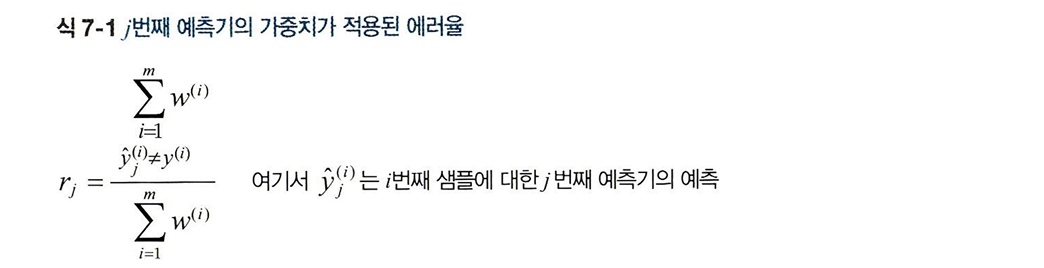

- 예측기가 정확할수록 가중치가 더 높아지게 된다.
- 만약 무작위로 예측하는 정도라면 가중치가 0에 가까울 것이다.

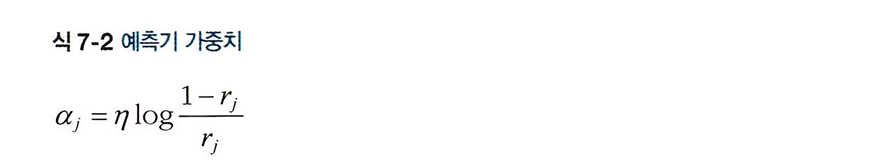

In [5]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators=200,
    algorithm='SAMME', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

**7.5.2 그레이디언트 부스팅**
- 에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다.
- 그러나 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킨다.

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

In [10]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [11]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [ ]:
#y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

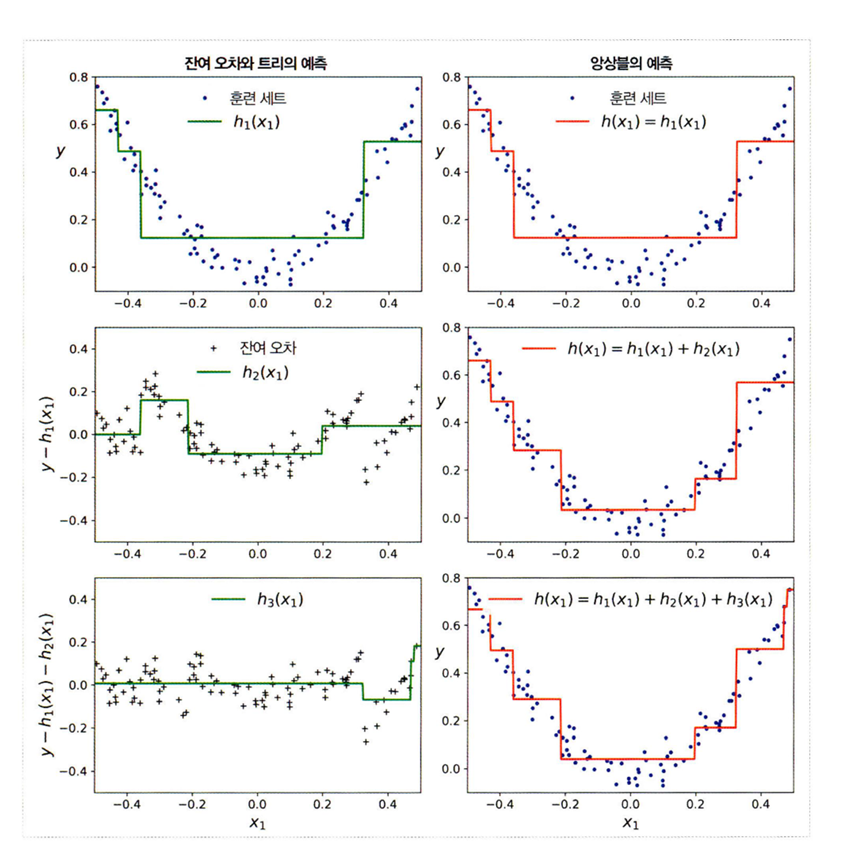

- learning_rate 매개변수가 각 트리의 기여 정도를 조절한다.
- 0.1 처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측 성능은 좋아진다. => '축소'

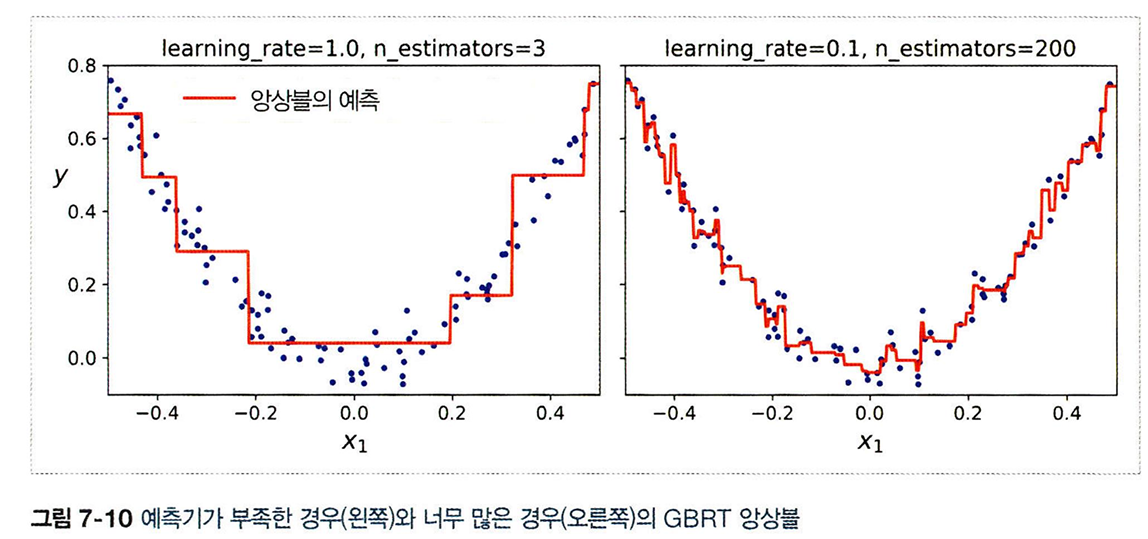

- 작은 학습률로 훈련시킨 두 개의 GBRT 앙상블을 보여준다.
- 왼쪽은 훈련 세트를 학습하기에는 트리가 충분하지 않은 반면 오른쪽은 트리가 너무 많아 훈련 세트에 과대적합되었다.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=41)

In [16]:
gbrt = GradientBoostingRegressor(max_depth=2,warm_start = True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train,y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val,y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  #조기 종료

- 편향이 높아지는 대신 분산이 낮아지게 된다. 또한 훈련 속도를 상당히 높인다.

  => 확률적 그레이디언트 부스팅

In [17]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

In [20]:
xgb_reg = xgboost.XGBRegressor(early_stopping_rounds = 2)
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_test, y_test)])
y_pred = xgb_reg.predict(X_test)

mean_squared_error(y_test, y_pred)

[0]	validation_0-rmse:0.36667
[1]	validation_0-rmse:0.26966
[2]	validation_0-rmse:0.20283
[3]	validation_0-rmse:0.16212
[4]	validation_0-rmse:0.14012
[5]	validation_0-rmse:0.11885
[6]	validation_0-rmse:0.10704
[7]	validation_0-rmse:0.09968
[8]	validation_0-rmse:0.09468
[9]	validation_0-rmse:0.09176
[10]	validation_0-rmse:0.09305


0.008419984951615334

# **7.6 스태킹**

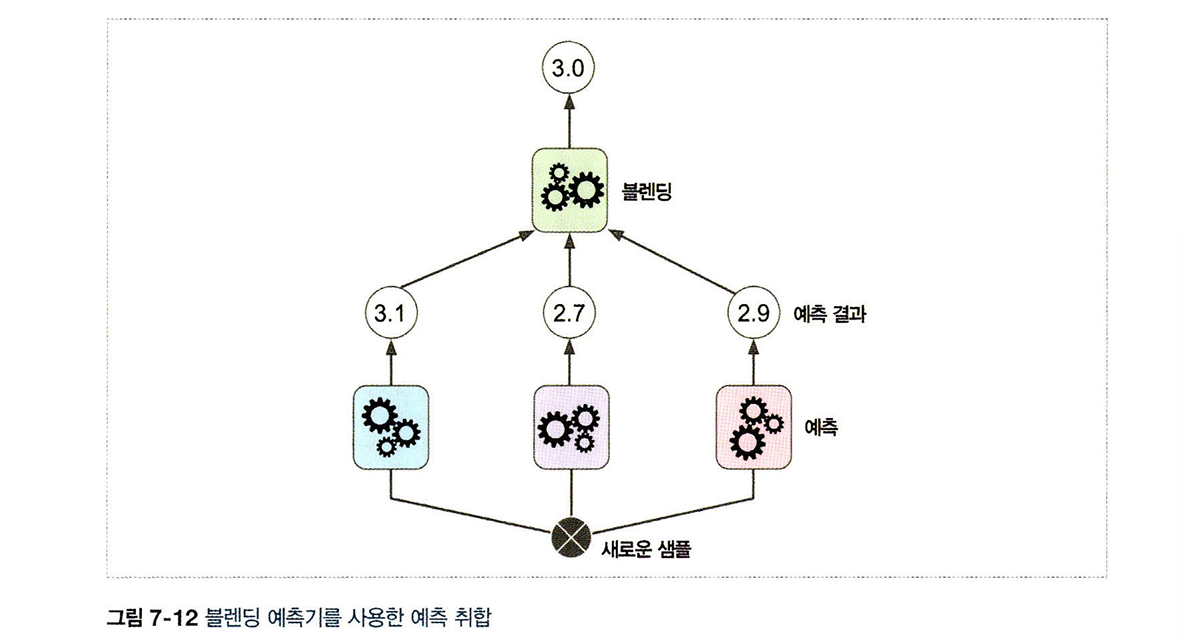
- 새로운 샘플에 회귀 작업을 수행하는 앙상블을 보여준다.
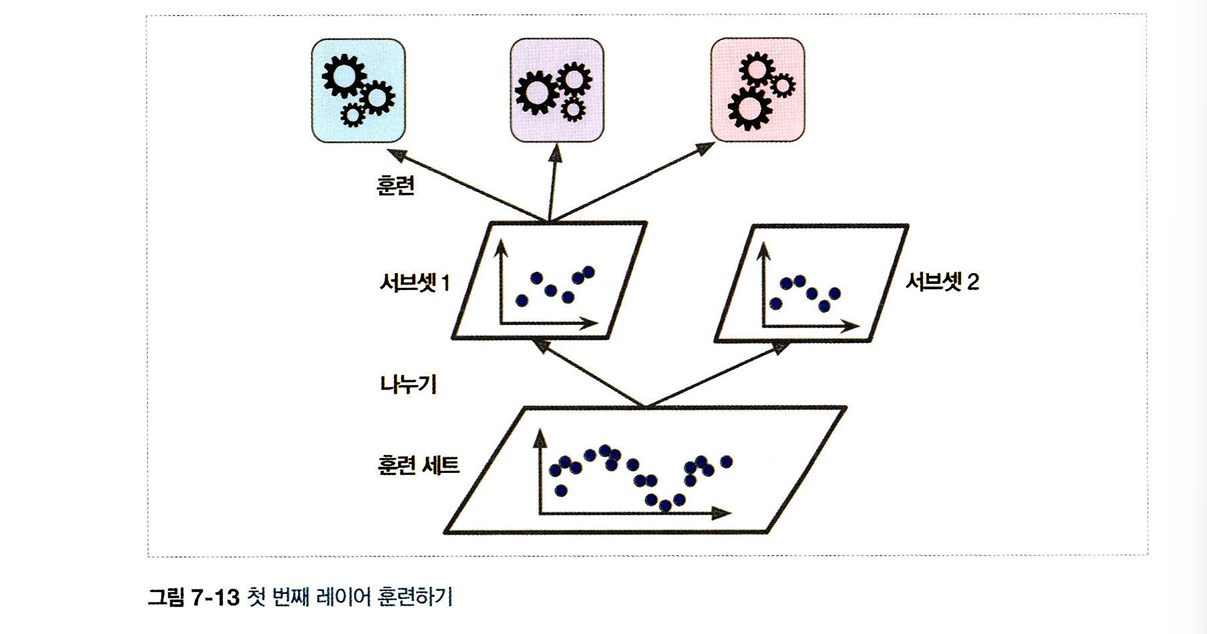
- 첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용된다.
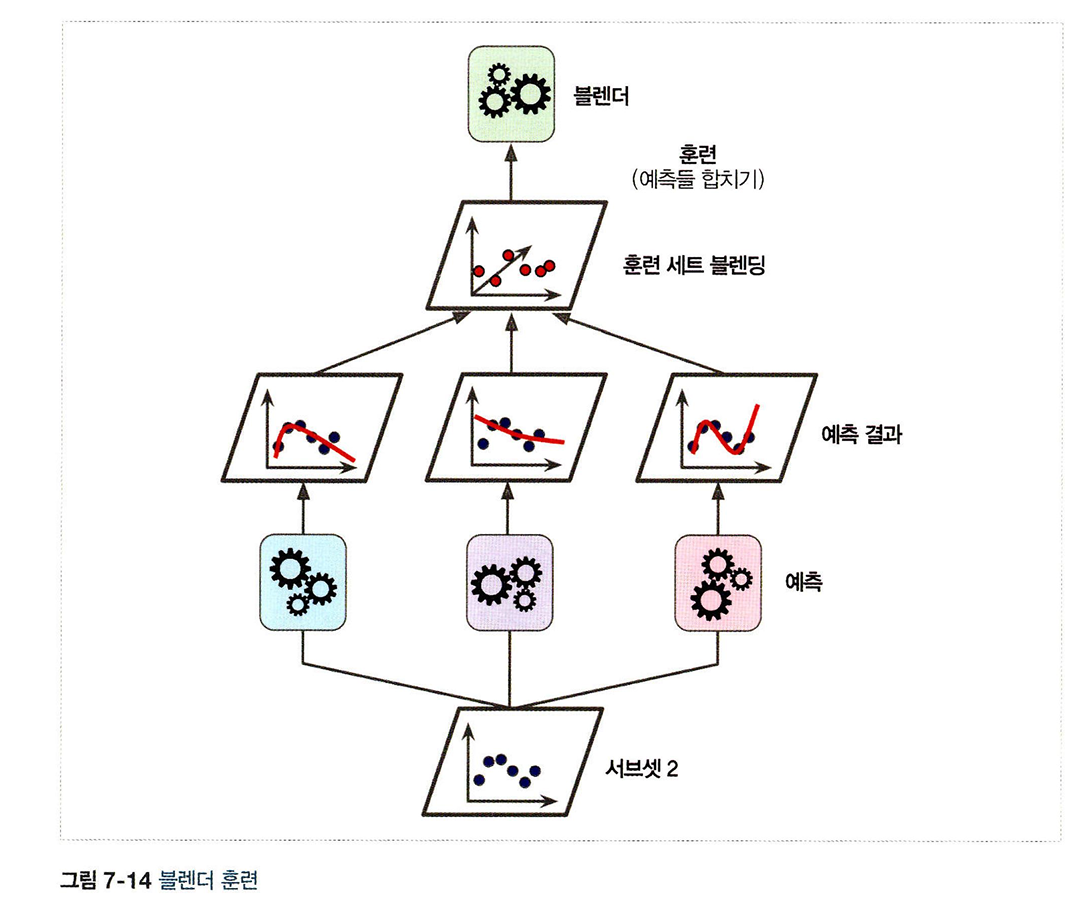
- 첫번째 레이어의 예측기를 사용해 두번째 세트에 대한 예측을 만든다.
- 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것이다.